### Librerías necesarias para el notebook + variables globales + cargamos los datasets 

In [13]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import json
# La conversión de divisas se establece aquí por si se quiere cambiar en el futuro. 
# En este notebook no se realiza, pero los datos serían más precisos si se tuviera en cuenta la inflación, por ejemplo.
CONVERSION_GBP = 1.14
CONVERSION_USD = 0.86

pd.options.mode.copy_on_write = True # Ponemos esta línea para saltarnos un warning específico

df_applist = pd.read_csv("../data/app_list.csv")
df_steam = pd.read_csv("../data/steam_app_data.csv")

### Funciones para la limpieza de datos

In [3]:
def string_a_valor(entrada, clave=None):
    """
    Convierte una cadena de texto que representa una estructura Python en un valor útil.

    La función intenta interpretar la entrada como una estructura Python válida
    (diccionario o lista). Dependiendo del tipo detectado, devuelve:

    - El valor asociado a una clave si es un diccionario.
    - True si es una lista de diccionarios (caso de demos).
    - El número de elementos si es una lista simple (caso de DLCs).
    - El valor original si no es posible interpretar la cadena.

    Parameters
    ----------
    entrada : str
        Cadena que representa un objeto Python (dict o list).

    clave : str, opcional
        Clave a recuperar si la entrada es un diccionario.

    Returns
    -------
    any
        Valor extraído, longitud de la lista, indicador booleano o la entrada original.
    """

    try: # En caso de que no sea un valor esperado, devolvemos el mismo valor
        obj = ast.literal_eval(entrada)
    except:
        return entrada
    else:
        if isinstance(obj, dict):
            return obj[clave]
        # Este caso sirve para tratar las columnas dlc y demos. Si el código llega hasta aquí, se tratará de una lista
        if isinstance(obj[0], dict): # Chequeo de la estructura de la columna demo, que es como [{'appid': int, 'description': str}]
            return True # Devuelve que sí tiene demo
        return len(obj) # Devuelve el número de dlc registrados

def establece_precio(entrada):
    """
    Calcula el precio normalizado en euros a partir de datos económicos estructurados.

    Extrae la divisa y el precio final desde una cadena que representa un diccionario.
    Se aplica el tipo de conversión correspondiente según la moneda.

    Divisas soportadas:
    - GBP
    - USD
    - EUR (por defecto)

    El precio original está multiplicado por 100 en el dataset, por lo que se revierte
    esta transformación antes de devolver el valor final.

    Parameters
    ----------
    entrada : str
        Cadena que representa la información de precios.

    Returns
    -------
    float o None
        Precio convertido a euros o None si no puede procesarse.
    """

    divisa = string_a_valor(entrada, "currency")
    # string_a_valor() devolverá el valor de entrada si ha surgido algún error. 
    # El error se deberá valores nulos, que resoldremos posteriormente.
    if divisa == entrada: 
        return None # Trataremos los valores nulos fuera de la función
    elif divisa == "GBP":
        precio = string_a_valor(entrada,"final") * CONVERSION_GBP
    elif divisa == "USD":
        precio = string_a_valor(entrada,"final") * CONVERSION_USD
    else:
        precio = string_a_valor(entrada,"final")
        # El precio está multiplicado por 100 en los datos originales. Por lo tanto, deshacemos esta multiplicación para obtener el precio.
    return np.round(precio/100,2)

def establece_fecha(entrada):
    """
    Extrae y formatea la fecha de lanzamiento de un videojuego.

    Si el título no está marcado como "coming soon", se utiliza la fecha proporcionada.
    En el caso contrario, se asigna como fecha por defecto el año 2019 (año de
    publicación del dataset).

    Los valores no válidos se convierten en NaT.

    Parameters
    ----------
    entrada : str
        Cadena que contiene información de fecha en formato de diccionario.

    Returns
    -------
    pandas.Timestamp
        Fecha interpretada o NaT si la conversión falla.
    """

    coming_soon = string_a_valor(entrada, "coming_soon")
    if not coming_soon: 
        fecha = string_a_valor(entrada, "date")
    else:
        fecha = '2019' # Si el juego estaba a punto de salir, asumiremos que salió el año en que se publicó este dataset
    return pd.to_datetime(fecha, errors='coerce')

def cambia_categorias_o_generos(entrada, d):
    """
    Procesa una lista de categorías o géneros almacenados como texto estructurado.

    La función interpreta la entrada como una lista de diccionarios del tipo:
    {'id': int, 'description': str}.

    Además de devolver una lista con los identificadores encontrados, va rellenando
    un diccionario global que relaciona los IDs con su descripción textual.

    Parameters
    ----------
    entrada : str
        Cadena que representa una lista de diccionarios.

    d : dict
        Diccionario donde se almacenan las relaciones id → nombre.

    Returns
    -------
    list o any
        Lista de IDs asociados o valor original si no puede interpretarse.
    """

    try: # En caso de que no sea un valor esperado, devolvemos el mismo valor
        lista_entrada = ast.literal_eval(entrada) # La cadena de texto es una lista de diccionarios
    except:
        return entrada
    else:
        lista_salida = [] # Lista que solo contendrá las claves de las categorías o géneros
        for elemento in lista_entrada:
            # Cada diccionario de la lista es de la estructura {'id': int, 'description': str}. 
            # Añadimos la categoría o género al diccionario 
            d[elemento['id']] = elemento['description']
            lista_salida.append(elemento['id'])
        return lista_salida
    
def limpia_app_data(df):
    """
    Limpia, transforma y normaliza un dataset de videojuegos procedente de Steam.

    Esta función recibe un DataFrame sin procesar y aplica una limpieza con las anotaciones del otro notebook.

    Además, devuelve los diccionarios de categorías y géneros encontrados durante el
    procesado para su reutilización posterior.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame original con los datos sin procesar.

    Returns
    -------
    df_clean : pandas.DataFrame
        DataFrame limpio, tipado y preparado para análisis.

    categorias : dict
        Diccionario que asocia el id de cada categoría con su descripción.

    generos : dict
        Diccionario que asocia el id de cada género con su descripción.
    """

    ## Primera parte: eliminar columnas, duplicados y valores nulos

    # Quitamos las columnas que no nos interesan
    df = df.drop(['type','fullgame','header_image','screenshots','movies','background', 'platforms'], axis=1)
    # Eliminamos los duplicados
    df = df.drop_duplicates()
    # Eliminamos las 149 filas que están llenas de valores nulos, exceptuando las columnas "name" y "steam_appid"
    no_nan = ["name", "steam_appid"] # columnas que sí que tendrán valores
    cols = df.columns.difference(no_nan) # selección de todas las columnas menos las que tendrán valores
    mask = df[cols].isna().all(axis=1) # de todo el dataframe, se filtraran las líneas con las condiciones estipuladas en el markdown anterior
    result = df[mask]
    df_clean = df.loc[~df.index.isin(result.index)]

    ## Segunda parte: cambios de tipos de las columnas (casos sencillos)

    cols = ['name', 'detailed_description','about_the_game','short_description','website','legal_notice',
               'drm_notice','ext_user_account_notice']
    df_clean[cols] =  df_clean[cols].astype("string")

    ## Tercera parte: cambios en el contenido de las celdas para un fácil acceso a la información
    
    # Los videojuegos con valor nulo en dlc significa que tienen 0 DLCs. Los videojuegos sin valor en demo significará que no tienen demo.
    df_clean["dlc"] = df_clean["dlc"].fillna(0)
    df_clean["demos"] = df_clean["demos"].fillna(False)
    # Cambiamos los valores de los videojuegos que tienen demos y DLCs.
    df_clean["dlc"] = df_clean["dlc"].apply(string_a_valor)
    df_clean["demos"] = df_clean["demos"].apply(string_a_valor)
    # Los videojuegos que no tengan valoración, recomendaciones y/o logros serán rellenados con 0.
    df_clean["metacritic"] = df_clean["metacritic"].fillna(0)
    df_clean["recommendations"] = df_clean["recommendations"].fillna(0)
    df_clean["achievements"] = df_clean["achievements"].fillna(0)
    # En caso de que tengan, se tratará el diccionario debidamente.
    df_clean["metacritic"] = df_clean["metacritic"].apply(string_a_valor, clave = "score")
    df_clean["recommendations"] = df_clean["recommendations"].apply(string_a_valor, clave = "total")
    df_clean["achievements"] = df_clean["achievements"].apply(string_a_valor, clave = "total")

    # De la fecha de publicación, primero obtendremos el string relacionado con la fecha del diccionario y luego corregiremos el formato
    df_clean["release_date"] = df_clean["release_date"].apply(establece_fecha)

    # Establecemos el precio final de los videojuegos no gratuitos.
    df_clean["price_overview"] = df_clean["price_overview"].apply(establece_precio)
    # Los videojuegos gratuitos tendrán un precio de 0. Aunque eliminaremos luego la columna is_free, 
    #   la tratamos como variable booleana para que el cálculo sea más rápido
    df_clean["is_free"] = df_clean["is_free"].astype("bool") 
    df_clean.loc[df_clean["is_free"], "price_overview"] = 0
    # Todos los videojuegos no gratuitos sin percio tendrán un precio equivalente a la media de los videojuegos no gratuitos.
    df_clean["price_overview"] = df_clean["price_overview"].astype("float64") 
    mean = df_clean.loc[df_clean["price_overview"] != 0, "price_overview"].mean() # Ignoramos los videojuegos gratuitos al calcular la media
    df_clean["price_overview"] = df_clean["price_overview"].fillna(mean)

    # Categorías y géneros: para no repetir tanto la información, almacenaremos en diccionarios los distintos tipos que se registren, 
    # y el dataframe almacenará la lista de las claves correspondientes.
    categorias = dict()
    generos = dict()
    df_clean["categories"] = df_clean["categories"].apply(cambia_categorias_o_generos, d = categorias)
    df_clean["genres"] = df_clean["genres"].apply(cambia_categorias_o_generos, d = generos)
    
    # Usamos regex en las columnas para eliminar el código HTML
    cols = ["supported_languages","pc_requirements","mac_requirements","linux_requirements","legal_notice","drm_notice","reviews"]
    #df_clean["supported_languages"] = df_clean["supported_languages"].str.replace(r"<[^>]+>|\*", "", regex=True).str.strip()
    df_clean[cols] = df_clean[cols].apply(lambda s: (
                                                s.astype("string")
                                                .str.replace(r"<[^>]+>|\*", "", regex=True)
                                                .str.replace(r"\\r|\\n|\\t", " ", regex=True)
                                                .str.strip()
                                            )
                                        )
    # En la columna supported_languages nos queda una estructura como "Idioma1, Idioma2". Aprovechamos para añadir los corchetes a estos strings.
    df_clean["supported_languages"] = df_clean["supported_languages"].where(
                                                                        df_clean["supported_languages"].isna(),
                                                                        "[" + df_clean["supported_languages"] + "]")
    # Aunque en la descripción de las columnas hemos definido que controller_support era booleana, 
    # en realidad el contenido de la columna son 'full' o NaN. Por lo tanto, tenemos que cambiar esta variable también
    df_clean["controller_support"] = df_clean["controller_support"].fillna(False)
    df_clean["controller_support"] = df_clean["controller_support"].replace('full', True)
    
    return df_clean, categorias, generos

### Limpieza de datos

In [4]:
df_clean_steam, cats, gens = limpia_app_data(df_steam)
df_clean_steam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29079 entries, 0 to 29234
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   name                     29078 non-null  string        
 1   steam_appid              29079 non-null  int64         
 2   required_age             29079 non-null  float64       
 3   is_free                  29079 non-null  bool          
 4   controller_support       29079 non-null  bool          
 5   dlc                      29079 non-null  int64         
 6   detailed_description     29053 non-null  string        
 7   about_the_game           29053 non-null  string        
 8   short_description        29053 non-null  string        
 9   supported_languages      29065 non-null  string        
 10  website                  19249 non-null  string        
 11  pc_requirements          29079 non-null  string        
 12  mac_requirements         29079 non-nu

C:\Users\marti\AppData\Local\Temp\ipykernel_27432\1753638292.py:244: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean["controller_support"] = df_clean["controller_support"].replace('full', True)


Observamos que el dataframe tiene los tipos que debería tener, además de que usa menos memoria respecto el dataframe de *exploracion_datasets.ipynb*

In [5]:
pd.set_option('display.max_columns', None)
df_clean_steam.head()

,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,supported_languages,website,pc_requirements,mac_requirements,linux_requirements,legal_notice,drm_notice,ext_user_account_notice,developers,publishers,demos,price_overview,packages,package_groups,metacritic,reviews,categories,genres,recommendations,achievements,release_date,support_info,content_descriptors
0,Counter-Strike,10,0.0,False,False,0,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,"[English, French, German, Italian, Spanish - S...",<NA>,"{'minimum': ' Minimum: 500 mhz processor, ...",{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...",<NA>,<NA>,<NA>,['Valve'],['Valve'],False,8.20,[7],"[{'name': 'default', 'title': 'Buy Counter-Str...",88,<NA>,"[1, 36, 37, 8]",[1],65735,0,2000-11-01,"{'url': 'http://steamcommunity.com/app/10', 'e...","{'ids': [2, 5], 'notes': 'Includes intense vio..."
1,Team Fortress Classic,20,0.0,False,False,0,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...,"[English, French, German, Italian, Spanish - S...",<NA>,"{'minimum': ' Minimum: 500 mhz processor, ...",{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...",<NA>,<NA>,<NA>,['Valve'],['Valve'],False,4.55,[29],"[{'name': 'default', 'title': 'Buy Team Fortre...",0,<NA>,"[1, 36, 37, 8]",[1],2802,0,1999-04-01,"{'url': '', 'email': ''}","{'ids': [2, 5], 'notes': 'Includes intense vio..."
2,Day of Defeat,30,0.0,False,False,0,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,"[English, French, German, Italian, Spanish - S...",http://www.dayofdefeat.com/,"{'minimum': ' Minimum: 500 mhz processor, ...",{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...",<NA>,<NA>,<NA>,['Valve'],['Valve'],False,4.55,[30],"[{'name': 'default', 'title': 'Buy Day of Defe...",79,<NA>,"[1, 8]",[1],1992,0,2003-05-01,"{'url': '', 'email': ''}","{'ids': [], 'notes': None}"
3,Deathmatch Classic,40,0.0,False,False,0,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,"[English, French, German, Italian, Spanish - S...",<NA>,"{'minimum': ' Minimum: 500 mhz processor, ...",{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...",<NA>,<NA>,<NA>,['Valve'],['Valve'],False,4.55,[31],"[{'name': 'default', 'title': 'Buy Deathmatch ...",0,<NA>,"[1, 36, 37, 8]",[1],931,0,2001-06-01,"{'url': '', 'email': ''}","{'ids': [], 'notes': None}"
4,Half-Life: Opposing Force,50,0.0,False,False,0,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,"[English, French, German, Korean]",<NA>,"{'minimum': ' Minimum: 500 mhz processor, ...",{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...",<NA>,<NA>,<NA>,['Gearbox Software'],['Valve'],False,4.55,[32],"[{'name': 'default', 'title': 'Buy Half-Life: ...",0,<NA>,"[2, 1, 8]",[1],4355,0,1999-11-01,"{'url': 'https://help.steampowered.com', 'emai...","{'ids': [], 'notes': None}"


Observamos que los campos donde podía haber HTML ahora quedan leíbles. A continuación juntaremos los dos dataframes para ver si conseguimos rellenar el nombre del videojuego que falta.

In [11]:
df_clean_steam = df_clean_steam.set_index("steam_appid")
df_applist = df_applist.set_index("appid")

df_clean_steam["name"] = df_clean_steam["name"].combine_first(df_applist["name"])

df_clean_steam = df_clean_steam.reset_index()
df_applist = df_applist.reset_index()

df_clean_steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29079 entries, 0 to 29078
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   steam_appid              29079 non-null  int64         
 1   name                     29078 non-null  object        
 2   required_age             29079 non-null  float64       
 3   is_free                  29079 non-null  bool          
 4   controller_support       29079 non-null  bool          
 5   dlc                      29079 non-null  int64         
 6   detailed_description     29053 non-null  string        
 7   about_the_game           29053 non-null  string        
 8   short_description        29053 non-null  string        
 9   supported_languages      29065 non-null  string        
 10  website                  19249 non-null  string        
 11  pc_requirements          29079 non-null  string        
 12  mac_requirements         29079 n

Aún así, no nos ha servido. Ahora mostraremos la fila:

In [12]:
df_clean_steam[df_clean_steam["name"].isna()]

,steam_appid,name,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,supported_languages,website,pc_requirements,mac_requirements,linux_requirements,legal_notice,drm_notice,ext_user_account_notice,developers,publishers,demos,price_overview,packages,package_groups,metacritic,reviews,categories,genres,recommendations,achievements,release_date,support_info,content_descriptors
7142,396420,NaN,0.0,True,False,0,Spookeningは3Dの恐怖ゲームで、あなたは毎夜に死んでゴーストとして復活します。<b...,Spookeningは3Dの恐怖ゲームで、あなたは毎夜に死んでゴーストとして復活します。<b...,Spookeningは3Dの恐怖ゲームで、あなたは毎夜に死んでゴーストとして復活します。 村...,<NA>,<NA>,{'minimum': 'Minimum:OS: Windows 7'},[],[],<NA>,<NA>,<NA>,NaN,[''],False,0.0,NaN,[],0,<NA>,NaN,NaN,0,0,2016-11-01,"{'url': '', 'email': ''}","{'ids': [], 'notes': None}"


Por las descripciones, observamos que el videojuego podría tener caracteres asiáticos en el nombre. Esto podría ser una causa de por qué el nombre no quedó bien registrado.

### Visualización de datos

A continuación realizaremos unas breves visualizaciones exploratorias de algunas de las columnas.

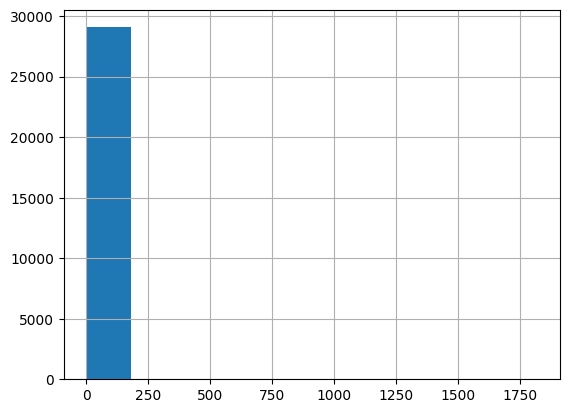

In [17]:
df_clean_steam["required_age"].hist(bins=10)
plt.show()

Vemos que por algún motivo, el histograma no se visualiza correctamente. Esto se debe a que hay un valor muy grande.

In [19]:
df_clean_steam["required_age"].nlargest(5)

28692    1818.0
19240      20.0
46         18.0
150        18.0
154        18.0
Name: required_age, dtype: float64

Por lo que sea, hay un valor de edad mínima a 1818 años. Suponemos que es un mal input y lo corregimos a 18.

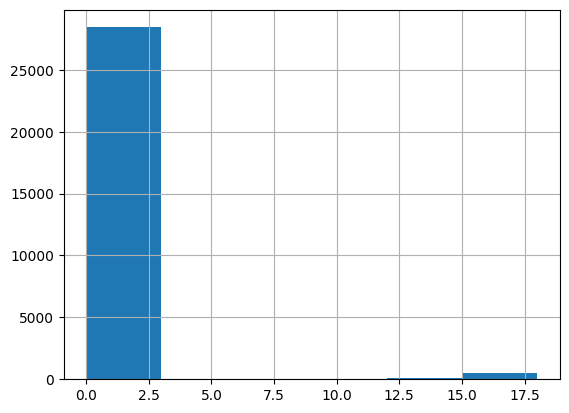

In [22]:
df_clean_steam.loc[df_clean_steam["required_age"] == df_clean_steam["required_age"].max(), "required_age"] = 18
df_clean_steam["required_age"].hist(bins=6)
plt.show()

Se han puesto pocos bins porque las restricciones de edad van más bien por grupos y no es un rango de valores real. Aún así, nos ha servido para detectar un error. El histograma en sí indica que la mayoría de videojuegos de los datos no tienen restricción de edad.

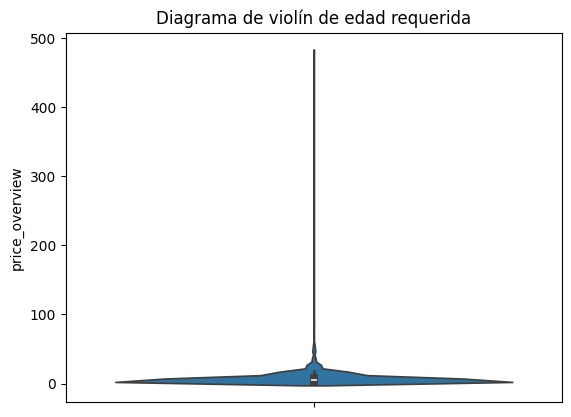

In [ ]:
sns.violinplot(y=df_clean_steam["price_overview"])
plt.title("Diagrama de violín del precio de los videojuegos")
plt.show()


In [24]:
df_clean_steam["price_overview"].nlargest(5)

22675    481.07
26542    350.21
14019    346.55
24820    340.86
13486    262.19
Name: price_overview, dtype: float64

Viendo que esta vez no ha sido un error puntual, podemos asumir que este dataset tiene outliers si nos fijamos en el precio de los videojuegos que habrá que tener en cuenta.

### Almacenamiento de los datos

In [ ]:
carpeta_datos_limpios = "clean-data"

df_clean_steam.to_csv("steam_data.csv", index=False, encoding="utf-8")

with open("categorias.json", "w", encoding="utf-8") as f:
    json.dump(cats, f, indent=4, ensure_ascii=False)

with open("generos.json", "w", encoding="utf-8") as f:
    json.dump(gens, f, indent=4, ensure_ascii=False)